# Random Forest

In [21]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
import pickle
import os
os.chdir('/sietch_colab/akapoor/Demographic_Inference/')
from src.utils import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


In [22]:
experiment_directory = '/sietch_colab/akapoor/Demographic_Inference/model1_results/Random_Forest/'
os.makedirs(experiment_directory, exist_ok=True)

In [23]:
# Import data
with open('/sietch_colab/akapoor/Demographic_Inference/model1_results/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

In [24]:
# Define the parameter distributions for random search
param_distributions = {
    'estimator__n_estimators': randint(100, 500),  # Uniform integer between 100 and 500
    'estimator__max_depth': [None] + list(randint(10, 50).rvs(5)),  # None and 5 random integers between 10 and 50
    'estimator__min_samples_split': randint(2, 20),  # Uniform integer between 2 and 20
    'estimator__min_samples_leaf': randint(1, 10),  # Uniform integer between 1 and 10
    'estimator__max_features': uniform(0.5, 0.5)  # Uniform float between 0.5 and 1.0
}

# Create the base Random Forest regressor
base_rf = RandomForestRegressor(
    n_jobs=-1,                # Use all CPU cores
    random_state=42           # For reproducibility
)

# Create the MultiOutputRegressor
multioutput_rf = MultiOutputRegressor(base_rf)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=multioutput_rf,
    param_distributions=param_distributions,
    n_iter=100,              # Number of parameter settings sampled
    cv=5,                    # 5-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,              # Use all CPU cores
    verbose=2,              # Print progress
    random_state=42         # For reproducibility
)

# Fit the random search to find the best parameters
print("Starting random search...")
random_search.fit(
    features_and_targets['training']['features'],
    features_and_targets['training']['targets']
)

# Print the best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print("\nBest cross-validation score:", -random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# Make predictions with the best model
train_predictions = best_model.predict(features_and_targets['training']['features'])
val_predictions = best_model.predict(features_and_targets['validation']['features'])

# Calculate MSE for each target variable
train_mse = mean_squared_error(
    features_and_targets['training']['targets'],
    train_predictions
)
val_mse = mean_squared_error(
    features_and_targets['validation']['targets'],
    val_predictions
)

# Store all results in a dictionary
results = {
    'best_model': best_model,
    'best_params': random_search.best_params_,
    'cv_score': -random_search.best_score_,
    'train_mse': train_mse,
    'validation_mse': val_mse,
    'random_search': random_search  # Keep the full random search results
}

Starting random search...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END estimator__max_depth=33, estimator__max_features=0.9753571532049581, estimator__min_samples_leaf=8, estimator__min_samples_split=8, estimator__n_estimators=221; total time=   1.8s
[CV] END estimator__max_depth=35, estimator__max_features=0.9010984903770198, estimator__min_samples_leaf=1, estimator__min_samples_split=8, estimator__n_estimators=108; total time=  19.8s
[CV] END estimator__max_depth=35, estimator__max_features=0.9858560476945519, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=104; total time=  21.9s
[CV] END estimator__max_depth=15, estimator__max_features=0.5035331526098588, estimator__min_samples_leaf=9, estimator__min_samples_split=18, estimator__n_estimators=158; total time=  23.7s
[CV] END estimator__max_depth=15, estimator__max_features=0.5035331526098588, estimator__min_samples_leaf=9, estimator__min_samples_split=18, estimator__n_estimators=158; total time=  23.8s
[CV] END estimator__max_depth=20, estimator__max_feat

In [25]:
results

{'best_model': MultiOutputRegressor(estimator=RandomForestRegressor(max_depth=15,
                                                      max_features=0.8167018782552118,
                                                      min_samples_leaf=6,
                                                      min_samples_split=13,
                                                      n_estimators=143,
                                                      n_jobs=-1,
                                                      random_state=42)),
 'best_params': {'estimator__max_depth': 15,
  'estimator__max_features': 0.8167018782552118,
  'estimator__min_samples_leaf': 6,
  'estimator__min_samples_split': 13,
  'estimator__n_estimators': 143},
 'cv_score': 0.0004893355797207455,
 'train_mse': 0.00022178546486972467,
 'validation_mse': 0.00033889502153883135,
 'random_search': RandomizedSearchCV(cv=5,
                    estimator=MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
              

In [26]:
# save the results
with open(f'{experiment_directory}/random_forest_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [29]:
train_predictions = best_model.predict(features_and_targets['training']['features'])
validation_predictions = best_model.predict(features_and_targets['validation']['features'])

In [30]:
model_obj = {}
model_obj['training'] = {}
model_obj['validation'] = {}

model_obj['training']['predictions'] = train_predictions
model_obj['validation']['predictions'] = validation_predictions

model_obj['training']['targets'] = features_and_targets['training']['targets']
model_obj['validation']['targets'] = features_and_targets['validation']['targets']

model_obj['param_names'] = [
            "Na",
            "N1",
            "N2",
            "t_split"
        ]


In [31]:
import numpy as np
import pandas as pd
def calculate_mse_df(dataset_type, linear_mdl_obj, model_name):
    """Calculate MSE and standard errors for a given dataset type (training or validation)"""
    params = linear_mdl_obj['param_names']
    mse_values = {}
    mse_errors = {}

    for i, param in enumerate(params):
        mse_values[param] = {}
        mse_errors[param] = {}
        target_values = linear_mdl_obj[dataset_type]['targets'][i]
        predictions = linear_mdl_obj[dataset_type]['predictions'][i]
        
        # Calculate MSE for each simulation
        squared_errors = (predictions - target_values) ** 2

        # Mean MSE across all simulations
        mse_values[param][f'{model_name}'] = np.mean(squared_errors)

        # Standard error of MSE across simulations
        mse_errors[param][f'{model_name}'] = np.std(squared_errors) / np.sqrt(len(squared_errors))

    # Create DataFrame
    result_df = pd.DataFrame({
        f'{model_name}': [mse_values[p][f'{model_name}'] for p in params],
        f'{model_name}_std_err': [mse_errors[p][f'{model_name}'] for p in params],
    }, index=params)
    
    return result_df

# Calculate MSE for both datasets
train_df_RF = calculate_mse_df('training', model_obj, 'Random_Forest')
val_df_RF = calculate_mse_df('validation', model_obj, 'Random_Forest')

print("Training MSE Values and Standard Errors:")
print(train_df_RF)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_RF)

Training MSE Values and Standard Errors:
         Random_Forest  Random_Forest_std_err
Na            0.000322               0.000185
N1            0.000230               0.000117
N2            0.000149               0.000067
t_split       0.002959               0.002282

Validation MSE Values and Standard Errors:
         Random_Forest  Random_Forest_std_err
Na            0.000193               0.000091
N1            0.000036               0.000017
N2            0.000457               0.000349
t_split       0.000033               0.000021


In [34]:
rf_model = results['best_model']

need to get the names of the features for feature importance

In [ ]:
with open('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

train_features = features_and_targets['training']['features']
validation_features = features_and_targets['validation']['features']

train_targets = features_and_targets['training']['targets']
validation_targets = features_and_targets['validation']['targets']

# Drop columns with "_m", "FIM", or "ll" in their names
train_features_mdl1 = train_features[
    train_features.columns[~train_features.columns.str.contains(r'_m|FIM|ll', case=False, regex=True)]
]
validation_features_mdl1 = validation_features[
    validation_features.columns[~validation_features.columns.str.contains(r'_m|FIM|ll', case=False, regex=True)]
]


In [42]:
train_features_mdl1

,dadi_rep1_Na,moments_rep1_Na,dadi_rep1_N1,moments_rep1_N1,dadi_rep1_N2,moments_rep1_N2,dadi_rep1_t_split,moments_rep1_t_split,dadi_rep2_Na,moments_rep2_Na,dadi_rep2_N1,moments_rep2_N1,dadi_rep2_N2,moments_rep2_N2,dadi_rep2_t_split,moments_rep2_t_split,momentsLD_Na,momentsLD_N1,momentsLD_N2,momentsLD_t_split
0,19260.928013,19308.973163,11923.469066,11940.278187,25662.858324,25543.496745,1887.406348,1878.621907,19260.916716,19308.958595,11923.487126,11940.226814,25662.887497,25543.886903,1887.411813,1878.616695,19039.244606,12136.260496,26540.136648,1880.557323
1,16739.867624,16787.448862,28308.987562,28294.659582,27394.557856,27382.379430,15634.506091,15637.656146,16739.666509,16785.009006,28308.894293,28303.981053,27394.556262,27380.397032,15634.829761,15636.795904,17293.251005,28339.335570,27363.714205,16237.699003
2,29154.876743,29193.933669,21122.069219,21135.213795,4018.536681,4026.230517,12492.603927,12496.332293,29188.946521,29192.009988,21083.604620,21138.010729,4017.891878,4025.983688,12531.919639,12494.068479,29488.113014,21645.500877,4040.579011,12865.523144
3,6492.312960,6524.674095,26265.239051,26247.535502,20426.286985,20613.607438,1039.622796,1031.725387,6485.397727,6525.275397,27329.638129,26299.284192,21208.618716,20615.392792,1037.849954,1031.109298,6244.174997,28150.117500,21409.183867,1038.951105
4,16331.949271,16356.405959,4009.324200,4016.374924,6359.820892,6366.914140,6016.588652,6027.735562,16331.821214,16353.653629,4009.314992,4015.828139,6359.783729,6366.928658,6015.975587,6015.819322,16238.836310,4028.539337,6496.426033,6200.148194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3055,23342.543298,23415.687867,24934.534015,24873.896585,21550.882469,21548.952286,4894.474661,4865.036575,23342.684707,23406.061802,24936.277328,24869.839707,21550.874508,21550.053556,4893.928517,4876.751403,23880.519655,24979.645755,21836.828722,4850.271894
3056,22130.473377,22171.878035,3812.050961,3815.548453,2293.820712,2299.416310,4206.976128,4220.952623,22121.492656,22166.560876,3805.279546,3818.794126,2289.228476,2303.463411,4183.492292,4228.760523,23501.924813,3876.365604,2323.144703,4207.904408
3057,25009.974665,25063.519416,15807.458655,15817.704749,20497.894883,20509.384633,6074.695873,6066.936786,25009.947706,25059.389276,15807.239238,15828.658771,20498.498702,20502.674234,6074.513456,6071.569707,25026.095942,15861.289905,20939.975514,6094.510162
3058,10431.179115,10451.333442,10860.509908,10869.959682,7891.603421,7898.982666,17176.892333,17196.595884,10430.788712,10458.198449,10860.668043,10868.259241,7891.666410,7898.329950,17177.263882,17184.392318,12077.473937,11691.330652,8614.949135,19340.807319


In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming rf_model is your trained Random Forest Regressor and X is your feature DataFrame
n_outputs = len(rf_model.estimators_)  # Number of outputs

# Access feature importances for each target
feature_importances_per_target = {}

parameters = ['Na', 'N1', 'N2', 't_split']

for output_idx in range(n_outputs):
    feature_importances_per_target[f"{parameters[output_idx]}"] = rf_model.estimators_[output_idx].feature_importances_

# Convert to DataFrame
feature_importances_df = pd.DataFrame(feature_importances_per_target, index=train_features_mdl1.columns)

# Print the feature importance for each output
print("Feature Importances per Output:")
print(feature_importances_df)

Feature Importances per Output:
                                Na        N1        N2   t_split
dadi_rep1_Na          2.428797e-01  0.000005  0.000004  0.000001
moments_rep1_Na       1.198907e-02  0.000005  0.000005  0.000001
dadi_rep1_N1          9.428429e-07  0.226361  0.000004  0.000001
moments_rep1_N1       8.882489e-07  0.073701  0.000005  0.000002
dadi_rep1_N2          7.344908e-07  0.000004  0.116480  0.000001
moments_rep1_N2       8.777449e-07  0.000004  0.008412  0.000002
dadi_rep1_t_split     7.474614e-07  0.000006  0.000005  0.429106
moments_rep1_t_split  9.222571e-07  0.000006  0.000005  0.002171
dadi_rep2_Na          3.699818e-02  0.000005  0.000005  0.000001
moments_rep2_Na       7.081155e-01  0.000004  0.000004  0.000001
dadi_rep2_N1          1.072961e-06  0.021323  0.000005  0.000002
moments_rep2_N1       8.168630e-07  0.672482  0.000006  0.000001
dadi_rep2_N2          7.898129e-07  0.000004  0.126368  0.000002
moments_rep2_N2       7.717865e-07  0.000004  0.743452  0.

<Axes: >

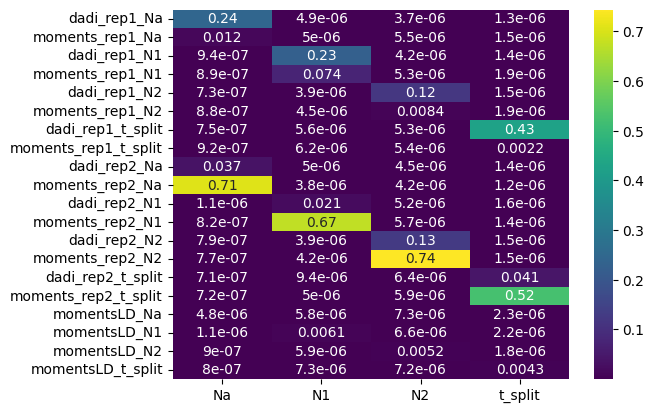

In [46]:
import seaborn as sns
sns.heatmap(feature_importances_df, cmap='viridis', annot=True)

# XGBoost 

In [12]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [13]:
experiment_directory = '/sietch_colab/akapoor/Demographic_Inference/model1_results/XGBoost/'
os.makedirs(experiment_directory, exist_ok=True)

In [14]:
# Import data
with open('/sietch_colab/akapoor/Demographic_Inference/model1_results/features_and_targets.pkl', 'rb') as f:
    features_and_targets = pickle.load(f)

In [15]:
# Define parameter distributions for random search
param_distributions = {
    'estimator__max_depth': randint(3, 10),
    'estimator__learning_rate': uniform(0.01, 0.3),
    'estimator__n_estimators': randint(100, 400),
    'estimator__subsample': uniform(0.6, 0.4),
    'estimator__colsample_bytree': uniform(0.6, 0.4),
    'estimator__min_child_weight': randint(1, 7),
    'estimator__gamma': uniform(0, 5)
}

# Create the base XGBoost regressor
# Note: We've removed early_stopping_rounds since we're using cross-validation
base_xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',
    n_jobs=-1,
    random_state=42
)

# Create the MultiOutputRegressor
multioutput_xgb = MultiOutputRegressor(base_xgb)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=multioutput_xgb,
    param_distributions=param_distributions,
    n_iter=25,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Starting XGBoost parameter optimization...")

# Fit the random search
random_search.fit(
    features_and_targets['training']['features'],
    features_and_targets['training']['targets']
)

# Calculate detailed metrics for the best model
best_model = random_search.best_estimator_
train_predictions = best_model.predict(features_and_targets['training']['features'])
val_predictions = best_model.predict(features_and_targets['validation']['features'])

# Calculate MSE for each target variable
train_mse = mean_squared_error(
    features_and_targets['training']['targets'],
    train_predictions
)
val_mse = mean_squared_error(
    features_and_targets['validation']['targets'],
    val_predictions
)

results = {
    'best_model': best_model,
    'best_params': random_search.best_params_,
    'cv_score': -random_search.best_score_,
    'train_mse': train_mse,
    'validation_mse': val_mse,
    'search_results': random_search.cv_results_
}

print("\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest cross-validation MSE: {-random_search.best_score_:.4f}")


Starting XGBoost parameter optimization...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=2.2962444598293357, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=357, estimator__subsample=0.8887995089067299; total time=   1.1s
[CV] END estimator__colsample_bytree=0.6399899663272012, estimator__gamma=2.2962444598293357, estimator__learning_rate=0.11011258334170654, estimator__max_depth=5, estimator__min_child_weight=6, estimator__n_estimators=357, estimator__subsample=0.8887995089067299; total time=   1.3s
[CV] END estimator__colsample_bytree=0.749816047538945, estimator__gamma=4.75357153204958, estimator__learning_rate=0.22959818254342154, estimator__max_depth=7, estimator__min_child_weight=5, estimator__n_estimators=202, estimator__subsample=0.7783331011414365; total time=   2.0s
[CV] END estimator__colsample_bytree=0.74981604

In [16]:
results

{'best_model': MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=0.9442922333025374,
                                             device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None,
                                             gamma=0.03476065265595352,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                       

In [17]:
# save the results
with open(f'{experiment_directory}/xgboost_results.pkl', 'wb') as f:
    pickle.dump(results, f)

In [18]:
train_predictions = best_model.predict(features_and_targets['training']['features'])
validation_predictions = best_model.predict(features_and_targets['validation']['features'])

In [19]:
model_obj = {}
model_obj['training'] = {}
model_obj['validation'] = {}

model_obj['training']['predictions'] = train_predictions
model_obj['validation']['predictions'] = validation_predictions

model_obj['training']['targets'] = features_and_targets['training']['targets']
model_obj['validation']['targets'] = features_and_targets['validation']['targets']

model_obj['param_names'] = [
            "Na",
            "N1",
            "N2",
            "t_split"
        ]


In [20]:
import numpy as np
import pandas as pd
def calculate_mse_df(dataset_type, linear_mdl_obj, model_name):
    """Calculate MSE and standard errors for a given dataset type (training or validation)"""
    params = linear_mdl_obj['param_names']
    mse_values = {}
    mse_errors = {}

    for i, param in enumerate(params):
        mse_values[param] = {}
        mse_errors[param] = {}
        target_values = linear_mdl_obj[dataset_type]['targets'][i]
        predictions = linear_mdl_obj[dataset_type]['predictions'][i]
        
        # Calculate MSE for each simulation
        squared_errors = (predictions - target_values) ** 2

        # Mean MSE across all simulations
        mse_values[param][f'{model_name}'] = np.mean(squared_errors)

        # Standard error of MSE across simulations
        mse_errors[param][f'{model_name}'] = np.std(squared_errors) / np.sqrt(len(squared_errors))

    # Create DataFrame
    result_df = pd.DataFrame({
        f'{model_name}': [mse_values[p][f'{model_name}'] for p in params],
        f'{model_name}_std_err': [mse_errors[p][f'{model_name}'] for p in params],
    }, index=params)
    
    return result_df

# Calculate MSE for both datasets
train_df_XGB = calculate_mse_df('training', model_obj, 'XGBoost')
val_df_XGB = calculate_mse_df('validation', model_obj, 'XGBoost')

print("Training MSE Values and Standard Errors:")
print(train_df_XGB)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_XGB)

Training MSE Values and Standard Errors:
          XGBoost  XGBoost_std_err
Na       0.001174         0.000565
N1       0.000299         0.000130
N2       0.000441         0.000173
t_split  0.005060         0.004161

Validation MSE Values and Standard Errors:
          XGBoost  XGBoost_std_err
Na       0.000447         0.000184
N1       0.000286         0.000088
N2       0.000438         0.000268
t_split  0.000151         0.000127


Load the linear model and calculate the same df

In [23]:
with open('/sietch_colab/akapoor/Demographic_Inference/model2_results/linear_mdl_obj.pkl', 'rb') as f:
    linear_mdl_obj = pickle.load(f)

In [24]:
# Calculate MSE for both datasets
train_df_mdl2 = calculate_mse_df('training', linear_mdl_obj, 'model2')
val_df_mdl2 = calculate_mse_df('validation', linear_mdl_obj, 'model2')

print("Training MSE Values and Standard Errors:")
print(train_df_mdl2)
print("\nValidation MSE Values and Standard Errors:")
print(val_df_mdl2)

Training MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.014813        0.009641
N1       0.008425        0.004305
N2       0.049813        0.038381
t_split  0.003485        0.001398

Validation MSE Values and Standard Errors:
           model2  model2_std_err
Na       0.010366        0.004936
N1       0.011478        0.005526
N2       0.039591        0.028196
t_split  0.034043        0.015178


In [25]:
import pandas as pd
momentsld_train = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_train.csv', index_col = 0)
momentsld_validation = pd.read_csv('/sietch_colab/akapoor/Demographic_Inference/sims_pretrain_5000_sims_inference_1_seed_42_num_replicates_3_top_values_2/mean_values_preprocess_validation.csv', index_col = 0)
# Using str.contains()
momentsLD_train = momentsld_train.loc[:, momentsld_train.columns.str.contains('MomentsLD')]
momentsLD_validation = momentsld_validation.loc[:, momentsld_validation.columns.str.contains('MomentsLD')]

# Merge dataframes horizontally
result_df1_train = pd.concat([momentsLD_train, train_df_RF, train_df_XGB], axis=1)
result_df1_validation = pd.concat([momentsLD_validation, val_df_RF, val_df_XGB], axis=1)

result_df1_train = pd.concat([result_df1_train, train_df_mdl2], axis = 1)
result_df1_validation = pd.concat([result_df1_validation, val_df_mdl2], axis = 1)


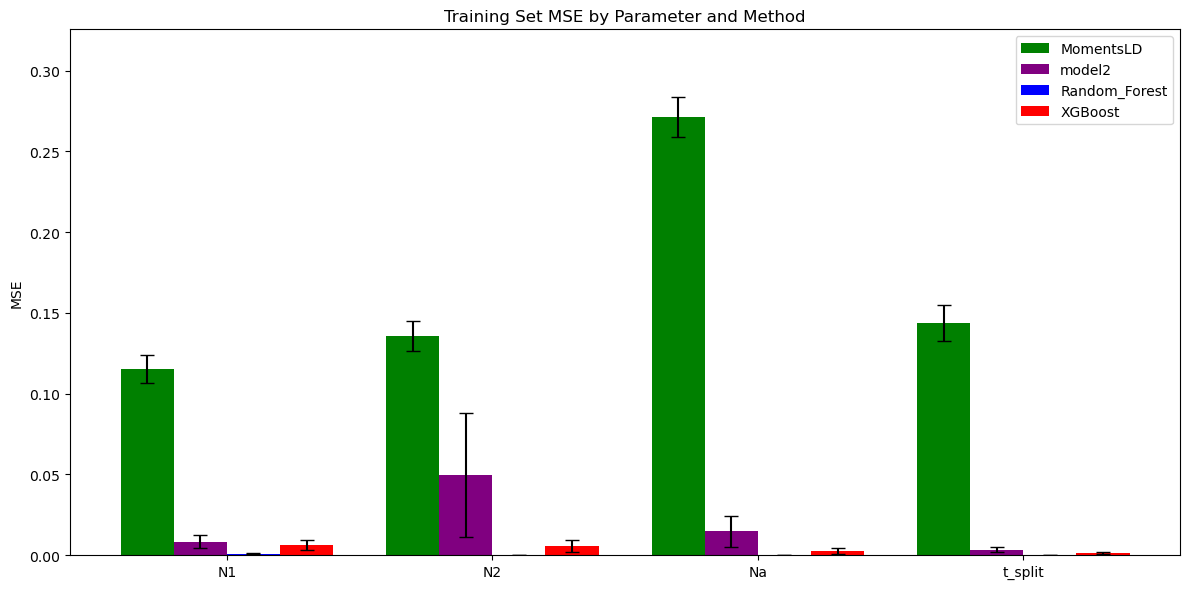

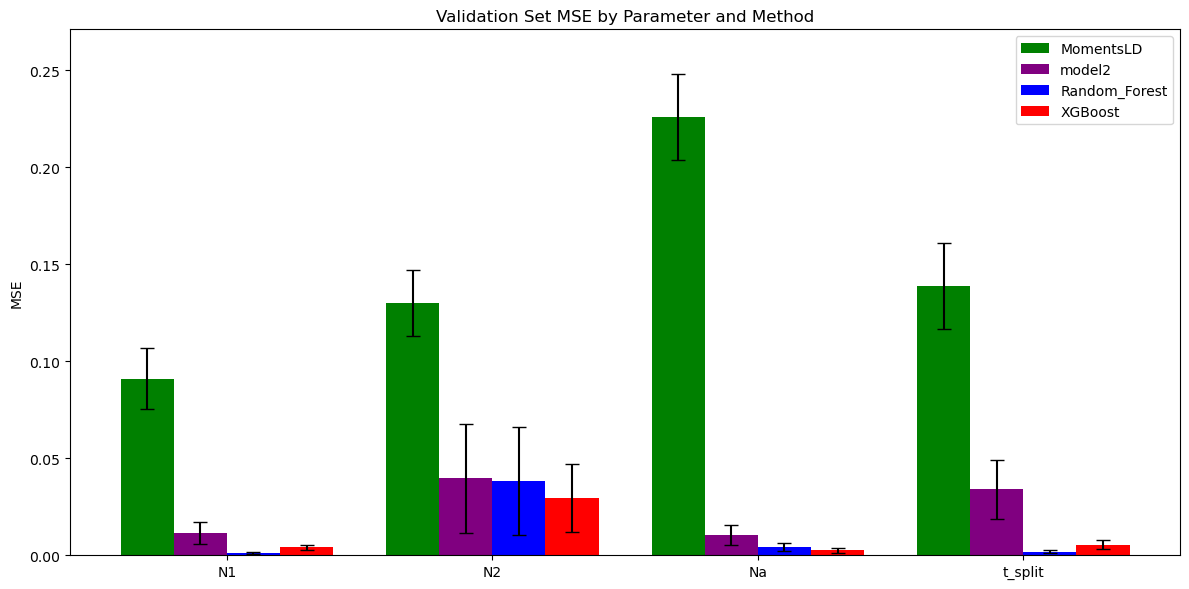

In [26]:
import matplotlib.pyplot as plt
def plot_comparison_barplot(result_df, model_names, title='MSE by Parameter and Method'):
    """
    Create grouped bar plot comparing multiple models' MSE values
    
    Parameters:
    -----------
    result_df : pandas DataFrame
        DataFrame containing MSE and std_err columns for each model
    model_names : list
        List of model names to plot
    title : str
        Title for the plot
    
    Returns:
    --------
    fig : matplotlib figure object
    """
    # Get parameter names (indices of DataFrame)
    params = result_df.index
    
    # Create grouped bar plot
    x = np.arange(len(params))
    n_models = len(model_names)
    width = 0.8 / n_models  # Adjust bar width based on number of models

    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors for each model
    colors = ['green', 'purple', 'blue', 'red', 'orange', 'brown']  # Add more colors if needed
    
    # Calculate positions for bars
    positions = np.linspace(-(width * (n_models-1)/2), width * (n_models-1)/2, n_models)
    
    # Create bars for each model
    rects = []
    for i, model_name in enumerate(model_names):
        rects.append(ax.bar(x + positions[i], 
                          result_df[model_name], 
                          width,
                          yerr=result_df[f'{model_name}_std_err'],
                          label=model_name, 
                          capsize=5, 
                          color=colors[i % len(colors)]))

    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.legend()

    # Add some padding to the top of the plot to show error bars fully
    max_val = max(result_df[model_names].max())
    ax.set_ylim(0, max_val * 1.2)

    plt.tight_layout()
    
    return fig

# Usage example:
model_names = ['MomentsLD', 'model2', 'Random_Forest','XGBoost']  # Add as many models as needed

# For training data
fig_train = plot_comparison_barplot(result_df1_train, 
                                  model_names, 
                                  "Training Set MSE by Parameter and Method")
plt.show()

# For validation data
fig_val = plot_comparison_barplot(result_df1_validation, 
                                model_names, 
                                "Validation Set MSE by Parameter and Method")
plt.show()